# Colab routines

In [1]:
!pip3 install torch

In [2]:
!git clone https://github.com/annafumagalli/LISA-M-project.git

Cloning into 'LISA-M-project'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 123 (delta 3), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (123/123), 5.93 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [3]:
cd ./LISA-M-project

/content/LISA-M-project


---------------------------------

In [1]:
import sys
sys.path.insert(0, '/home/annaf/LDC_project/masters_project/lib/python3.6/site-packages')

In [2]:
%matplotlib inline
import numpy as np
from scipy.signal import chirp
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchsummary import summary

from CDAE_model import *
from CDAE_training import *
import MBH_phenomD as mbhb_ph

import copy
import random
import cv2

/home/annaf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Training datasets

Randomly generate different type of signals within fixed parameter ranges and mix them together to create traning datasets.

- 100 mixed signals + clean/target sources signals

In [4]:
def normalise(x):
    y = (x - x.min())/(x.max() - x.min())
    return y

In [5]:
# Plots ranges, LISA freqs and time

extent = [0, 30, 1e-5, 1e0]    # 0-30 days, 1e-5-1 Hz

In [6]:
# Fixed dataset parameters

n = 1000      # number of training sets per batch
T = 60*10     # 10 min of data, sampled every 0.1 s
fs = 10       # sampling frequency
N = T*fs
t = np.linspace(0,T,N)

# FFT parameters

NFFT = 20*fs   # FTT time interval
NOVL = NFFT*0.71      # overlap
window = np.blackman(NFFT) 

## Sine waves

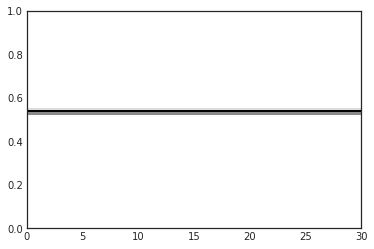

In [7]:
# Fixed:
# amplitude
a = 1.0 

# Varying:
# frequency
freq_sin = np.random.uniform(1.0, 4.0, n)

# Time Series

ts_s_train = np.zeros((n,N))
for i in range(n):
    ts_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t)
    
# Spectrograms

s_train = []
for i in range(n):
    temp1, _, _ = plt.mlab.specgram(ts_s_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    s_train.append(temp1)

s_train = np.array(s_train)
s_train = s_train[:,:100,:100]

plt.imshow(s_train[40], aspect='auto', origin='lower', extent=extent)

In [8]:
s_train.shape

(1000, 100, 100)

## Sine Gaussians  - not used

In [9]:
# Fixed:
# amplitude
#a = 1.0
# envelope parameter
#tau = 40.0
#frequency
#freq_sg = 4.5

# Varying:
# pulse starting time
#t0_sg = np.random.uniform(100.0, 200.0, n)


# Time Series

#ts_sg_train = np.zeros((n,N))
#for i in range(n):
#    ts_sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*freq_sg*(t-t0_sg[i])))
    
# Spectrograms

#sg_train = []
#for i in range(n):
    
#    temp1, _, _ = plt.mlab.specgram(ts_sg_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
#    sg_train.append(temp1)

#sg_train = np.array(sg_train)
#sg_train = sg_train[:,:100,:100]

#plt.imshow(sg_train[0], aspect='auto', origin='lower', extent=extent)

## Chirps

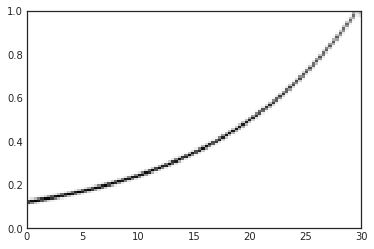

In [10]:
# Fixed:
# amplitude
a = 1.0
# Chirping time
t1 = 350.0

# Varying:
# Chirp frequencies
f0 = np.random.uniform(0.5, 1.5, n)
f1 = np.random.uniform(1.5, 2.5, n)

# Time Series

ts_chirp_train = np.zeros((n,N))
for i in range(n):
    k = (f1[i]/f0[i])**(1/(t1))  
    ts_chirp_train[i,:] = a*np.sin(2.0*np.pi*f0[i]*((k**t-1)/np.log(k)))
    
# Spectrograms

chirp_train = []
for i in range(n):
    
    temp1, freq, _ = plt.mlab.specgram(ts_chirp_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    chirp_train.append(temp1)

chirp_train = np.array(chirp_train)
chirp_train = chirp_train[:,:100,:100]

plt.imshow(chirp_train[10], aspect='auto', origin='lower', extent=extent)

## Truncated chirps

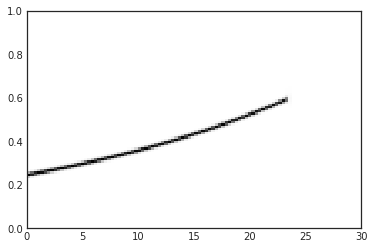

In [11]:
# Fixed:
# amplitude
a = 1.0
# Chirping time
t1 = 250.0

# Varying:
# Chirp frequencies
f0 = np.random.uniform(0.5, 1.5, n)
f1 = np.random.uniform(1.5, 2.5, n)

# Time Series

ts_tchirp_train = np.zeros((n,N))
for i in range(n):
    k = (f1[i]/f0[i])**(1/(t1))  
    ts_tchirp_train[i,:4600] = a*np.sin(2.0*np.pi*f0[i]*((k**t[:4600]-1)/np.log(k)))
    ts_tchirp_train[i, 4600:] == 0
    
# Spectrograms

tchirp_train = []
for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_tchirp_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    tchirp_train.append(temp1)
    
tchirp_train = np.array(tchirp_train)
tchirp_train = tchirp_train[:,:100,:100]

plt.imshow(tchirp_train[200], aspect='auto', origin='lower', extent=extent)

## Frequency modulated sine waves

In [12]:
# Fixed:
# amplitude
a = 1.0
# modulation frequency
fm = 20.0

# Varying:
# amplitude
a = 1.0
# carrier frequency
fc = np.random.uniform(1.0, 4.0, n)
# modulation index
B = np.random.uniform(50.0, 200.0, n)
# phase
phi = np.random.uniform(0.0, 2*np.pi, n)

# Time Series

ts_ms_train = np.zeros((n,N))
for i in range(n):
    ts_ms_train[i,:] = a*np.sin(2*np.pi*fc[i]*t + B[i]*np.sin(2*np.pi*fm*t + phi[i]))
    
# Spectrograms

ms_train = []
for i in range(n):
    temp1, _, _ = plt.mlab.specgram(ts_ms_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    ms_train.append(temp1)

ms_train = np.array(ms_train)
ms_train = ms_train[:,:100,:100]

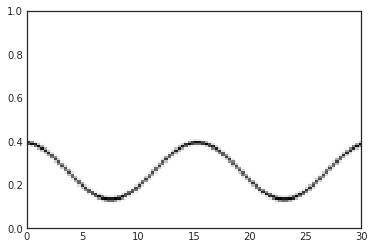

In [13]:
plt.imshow(ms_train[0], aspect='auto', origin='lower', extent=extent)

## MBHB

In [14]:
# To create MBHB spectrograms will define new (longer) time vector

#Define the time range
dt = 20.0
Tobs = 15*24*3600  # 2 weeks of data, cadence 20 seconds
Nbh = int(Tobs/dt)   # number of data point = 64800

tvec = np.arange(Nbh)*dt

# Define the generation of templates
theta = []

theta.append(0.5)            #[0] 'beta' - EclipticLatitude
theta.append(1.2)            #[1] 'lambda' - EclipticLongitude
theta.append(3000.0)         #[2] 'mc' - chirp mass
theta.append(1.5)            #[3] 'q' - mass ratio
theta.append(0.91)           #[4] 'chi1' - magnitude Spin1 [-1,1]
theta.append(0.9)            #[5] 'chi2' - magnitude Spin2 [-1,1]
theta.append(10*24*3600)     #[6] 'Tc' - CoalescenceTime

# Fixed:
 # 'beta' - EclipticLatitude
 # 'lambda' - EclipticLongitude
 # 'q' - mass ratio
 # 'chi1' - magnitude Spin1 [-1,1]
 # 'chi2' - magnitude Spin2 [-1,1]

# Varying:
 # 'mc' - chirp mass
mc = np.random.uniform(3000.0, 10000.0, n)
 #'Tc' - CoalescenceTime
tc = np.random.uniform(10*24*3600, 20*24*3600, n)

# Time Series

ts_mbhb_train = np.zeros((n,Nbh-2))
for i in range(n):
    theta[2] = mc[i]
    theta[6] = tc[i]
    mbh = mbhb_ph.MBHB_phenomD(theta)
    freq, Af, Ef = mbh.TDI_signal(tvec)
    tm, ts_mbhb_train[i,:] = mbhb_ph.ComputeTD(Af,dt)

In [15]:
# FFT parameters

NFFT1 = 1000 #FTT time interval
NOVL1 = NFFT1*0.88     # overlap
window1 = np.blackman(NFFT1) 

# Spectrograms

mbhb_train = []
for i in range(n):
    temp1, _, _ = plt.mlab.specgram(ts_mbhb_train[i, :], NFFT=NFFT1, Fs=1/dt, window=window1, noverlap=NOVL1)
    temp1 = cv2.resize(temp1, dsize=(100, 100))
    temp1 = normalise(temp1)
    mbhb_train.append(temp1)

mbhb_train = np.array(mbhb_train)    

(1000, 64798) (1000, 100, 100)


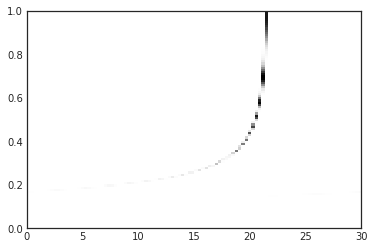

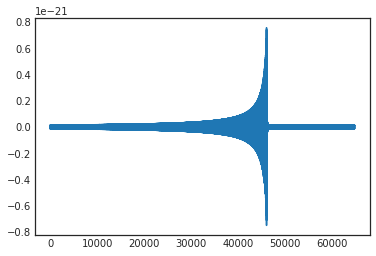

In [25]:
print(ts_mbhb_train.shape, mbhb_train.shape)

plt.imshow(mbhb_train[10], aspect='auto', origin='lower', extent=extent)
plt.show()

plt.plot(ts_mbhb_train[10])
plt.show()

## Mixtures

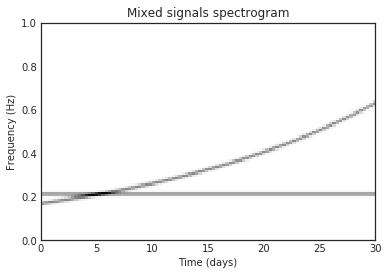

In [18]:
# MIX 1: Sine + sine gaussian

mix1_train = s_train + chirp_train

# Normalise data arrays between [0, 1] for training

s_train = normalise(s_train)
chirp_train = normalise(chirp_train)
mix1_train = normalise(mix1_train)

plt.imshow(mix1_train[10], aspect='auto', origin='lower', extent=extent)
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.title('Mixed signals spectrogram')

plt.show()

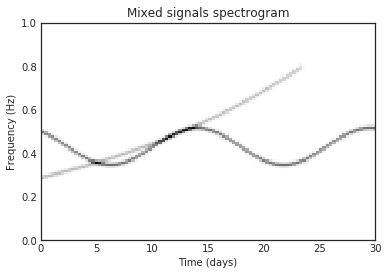

In [17]:
# MIX 2: Truncated chirp + frequency modulated sine

mix2_train = tchirp_train + ms_train

# Normalise data arrays between [0, 1] for training

ms_train = normalise(ms_train)
tchirp_train = normalise(tchirp_train)
mix2_train = normalise(mix2_train)

plt.imshow(mix2_train[20], aspect='auto', origin='lower', extent=extent)
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.title('Mixed signals spectrogram')

plt.show()

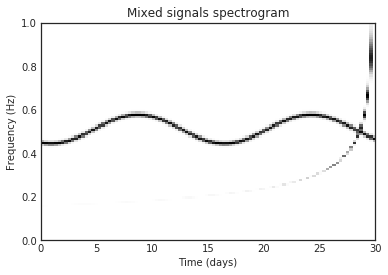

In [20]:
# MIX 3: MBHB + frequency modulated sine

mix3_train = normalise(ms_train)+mbhb_train

# Normalise data arrays between [0, 1] for training

ms_train = normalise(ms_train)
#mbhb_train = normalise(mbhb_train)
mix3_train = normalise(mix3_train)

plt.imshow(mix3_train[0], aspect='auto', origin='lower', extent=extent)
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.title('Mixed signals spectrogram')

plt.show()

# Model

- Architecture is the same for each source. One net per source.
- Basically a convolutional AE
- Loss function is the mean square error between the output and the clean target.
- Weights initiated randomly

In [16]:
model = CDAE().to(device)

summary(model, (1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 100, 100]           2,250
              Tanh-2         [-1, 10, 100, 100]               0
         MaxPool2d-3           [-1, 10, 50, 50]               0
            Conv2d-4           [-1, 20, 50, 50]           5,000
              Tanh-5           [-1, 20, 50, 50]               0
         MaxPool2d-6           [-1, 20, 10, 10]               0
            Conv2d-7           [-1, 30, 10, 10]          15,000
              Tanh-8           [-1, 30, 10, 10]               0
            Conv2d-9           [-1, 40, 10, 10]          30,000
             Tanh-10           [-1, 40, 10, 10]               0
  ConvTranspose2d-11           [-1, 30, 50, 50]          30,000
             Tanh-12           [-1, 30, 50, 50]               0
  ConvTranspose2d-13         [-1, 20, 100, 100]           2,400
             Tanh-14         [-1, 20, 1

# Training

start training...
epoch 0, loss 0.012421665713191032


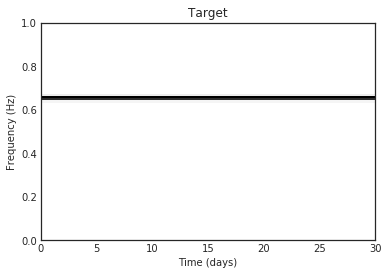

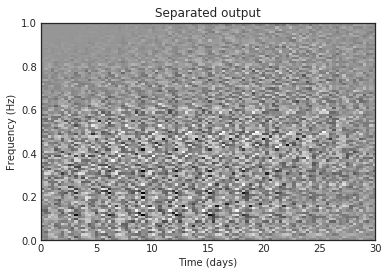

epoch 1000, loss 6.707184365950525e-05


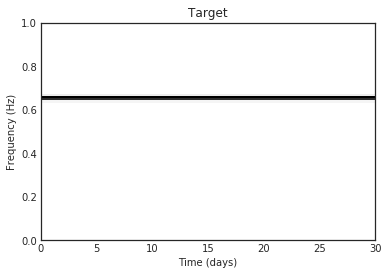

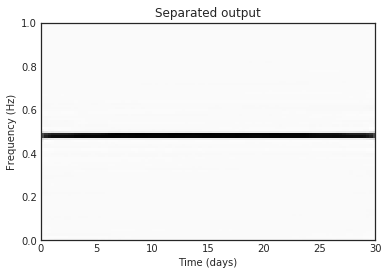

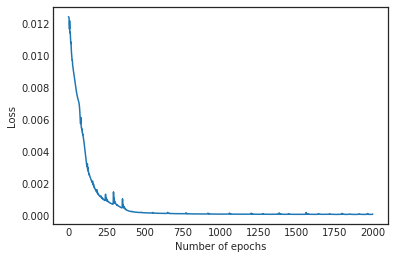

Saving trained model...
Model sine_net_26-02-2019_11:12:12.pt saved.


In [17]:
# MIX 1

# Sine

model = CDAE().to(device)

trainer = CDAE_trainer(model=model,
                       path='/home/annaf/LDC_project/masters_project/saved_models',
                       #path='/content/LISA-M-project',
                       filename='sine_net')

print('start training...')
trainer.train(mixed_input=mix1_train,
              target=s_train,
              n=n,
              device=device,
              batch_size=n,
              epochs=2000,
              H=100,
              W=100)

In [72]:
# MIX 1

# Sine gaussian

#model = CDAE().to(device) #redefining the model re-randomises the weights after previous training

#trainer = CDAE_trainer(model=model,
#                       path='/home/annaf/LDC_project/masters_project/saved_models',
#                       #path='/content/LISA-M-project',
#                       filename='sg_net')

#print('start training...')
#trainer.train(mixed_input=mix1_train,
#              target=sg_train,
#              n=n,
#              device=device,
#              batch_size=n,
#             epochs=5000,
#              H=100,
#              W=100)

start training...
epoch 0, loss 0.004425253253430128


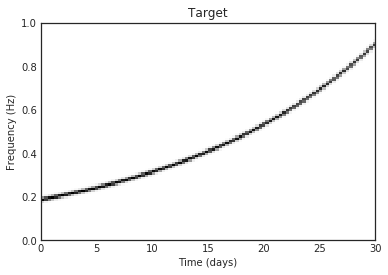

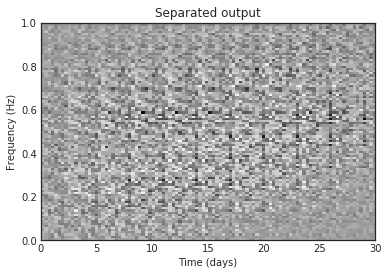

epoch 1000, loss 0.00037870171945542097


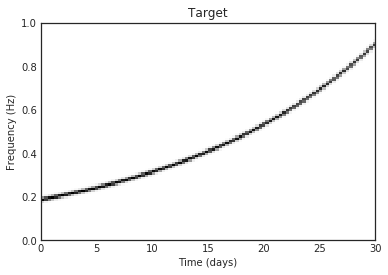

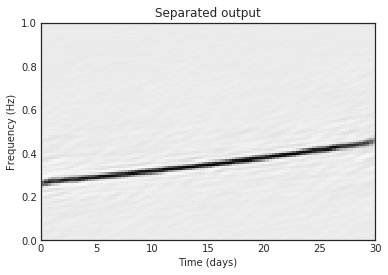

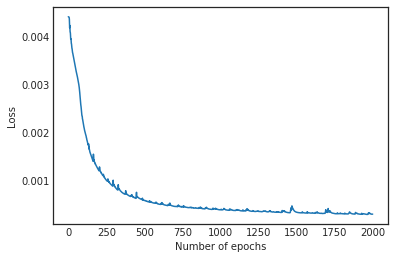

Saving trained model...
Model chirp_net_26-02-2019_11:27:28.pt saved.


In [18]:
# MIX 1

# Chirp

model = CDAE().to(device)

trainer = CDAE_trainer(model=model,
                       path='/home/annaf/LDC_project/masters_project/saved_models',
                       #path='/content/LISA-M-project',
                       filename='chirp_net')

print('start training...')
trainer.train(mixed_input=mix1_train,
              target=chirp_train,
              n=n,
              device=device,
              batch_size=n,
              epochs=2000,
              H=100,
              W=100)

------------------------------

start training...
epoch 0, loss 0.0032757569570094347


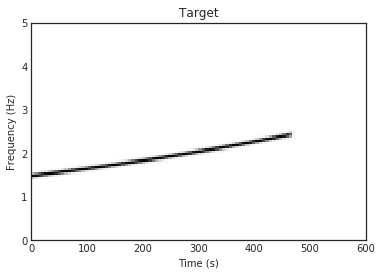

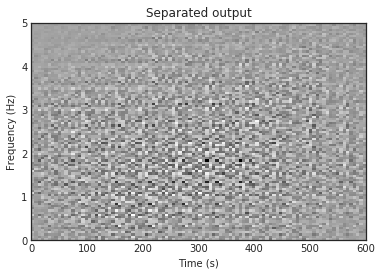

epoch 1000, loss 0.0007036992465145886


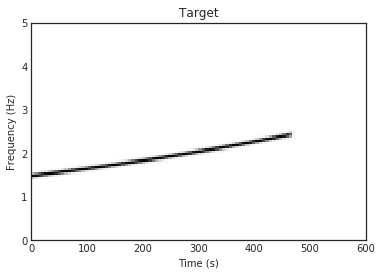

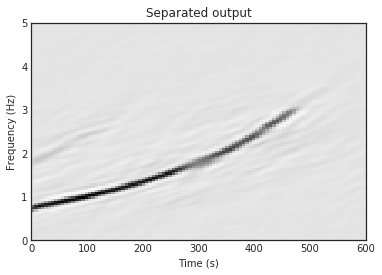

epoch 2000, loss 0.0006199419731274247


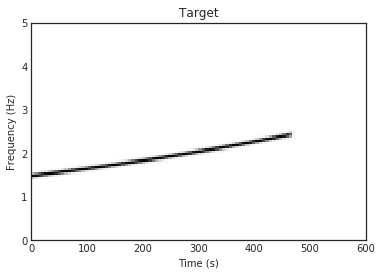

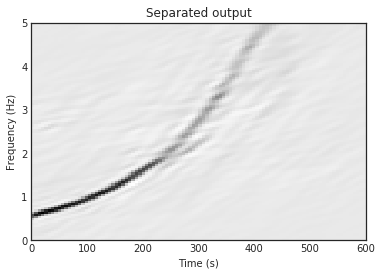

epoch 3000, loss 0.0005628293729387224


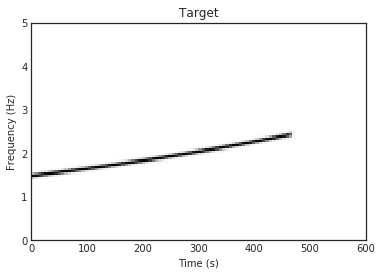

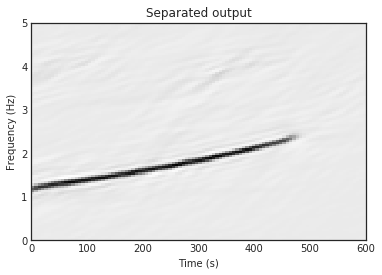

epoch 4000, loss 0.0005464816349558532


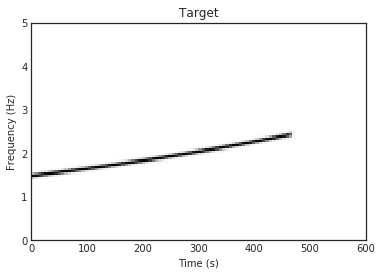

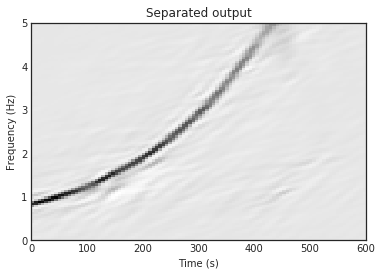

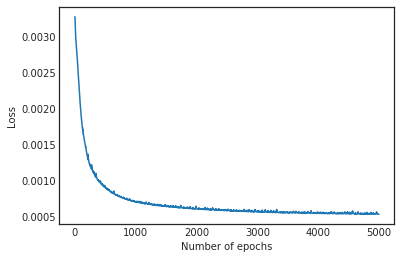

Saving trained model...
Model tchirp_net_14-02-2019_19:26:29.pt saved.


In [18]:
# MIX 2 

# Truncated chirp

model = CDAE().to(device)

trainer = CDAE_trainer(model=model,
                       path='/home/annaf/LDC_project/masters_project/saved_models',
                       #path='/content/LISA-M-project',
                       filename='tchirp_net')


print('start training...')
trainer.train(mixed_input=mix2_train,
              target=tchirp_train,
              n=n,
              device=device,
              batch_size=n,
              epochs=5000,
              H=100,
              W=100)

start training...
epoch 0, loss 0.011531094089150429


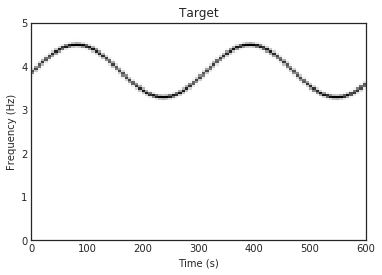

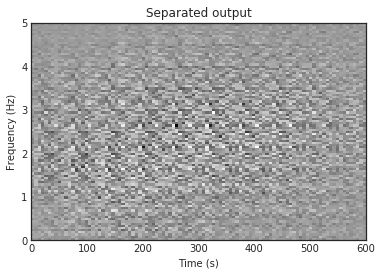

epoch 1000, loss 0.0038888808339834213


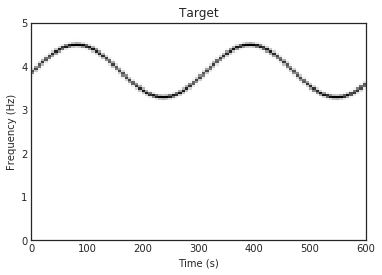

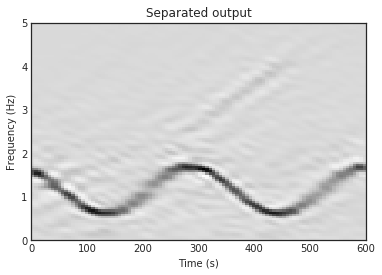

epoch 2000, loss 0.0035464721731841564


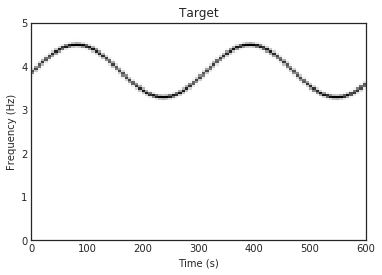

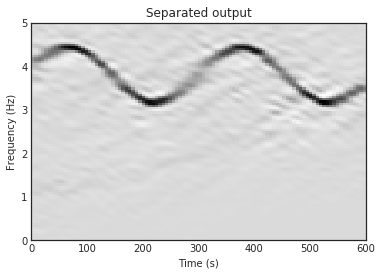

epoch 3000, loss 0.0032059019431471825


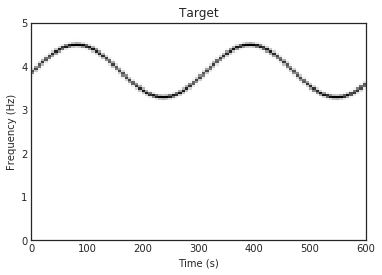

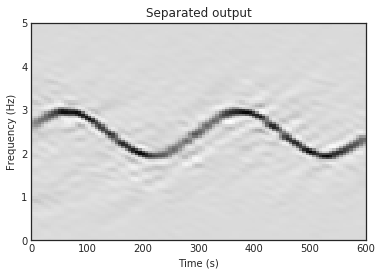

epoch 4000, loss 0.00305921770632267


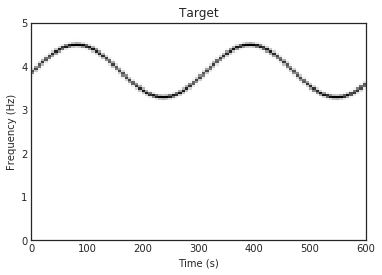

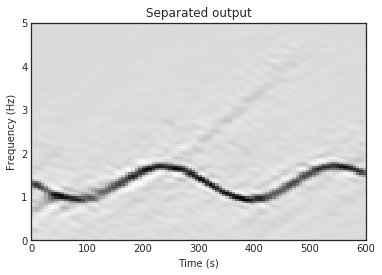

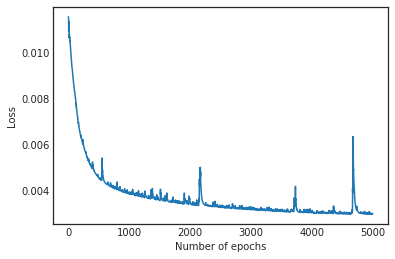

Saving trained model...
Model ms_net_14-02-2019_19:55:00.pt saved.


In [19]:
# MIX 2 

# Frequency modulated sine

model = CDAE().to(device)

trainer = CDAE_trainer(model=model,
                       path='/home/annaf/LDC_project/masters_project/saved_models',
                       #path='/content/LISA-M-project',
                       filename='ms_net')


print('start training...')
trainer.train(mixed_input=mix2_train,
              target=ms_train,
              n=n,
              device=device,
              batch_size=n,
              epochs=5000,
              H=100,
              W=100)

-------------------

start training...
epoch 0, loss 0.0004976586205884814


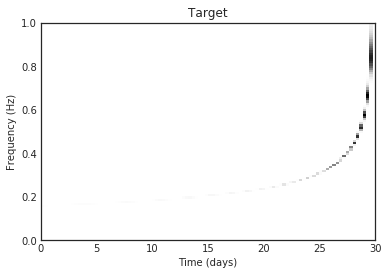

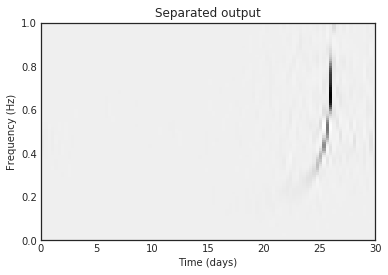

epoch 1000, loss 0.00046915331040509045


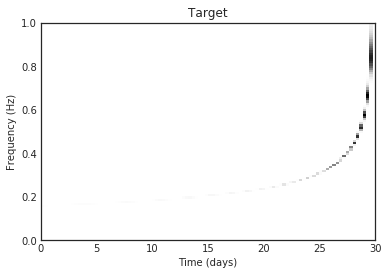

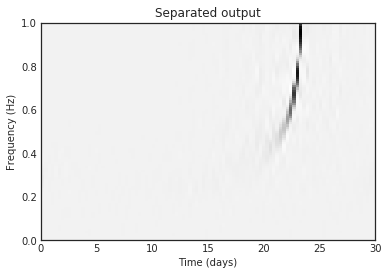

epoch 2000, loss 0.00045261610648594797


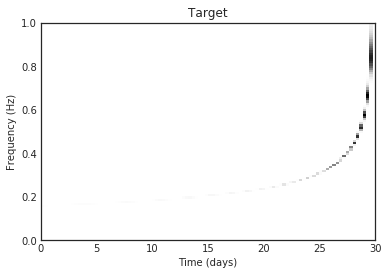

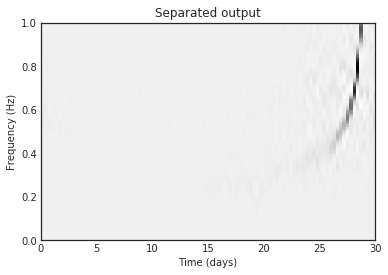

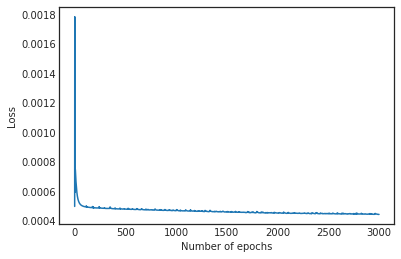

Saving trained model...
Model mbhb_net_26-02-2019_14:42:45.pt saved.


In [23]:
# MIX 3 

# MBHB

model = torch.load('./saved_models/mbhb_net_26-02-2019_13:45:57.pt')


trainer = CDAE_trainer(model=model,
                       path='/home/annaf/LDC_project/masters_project/saved_models',
                       #path='/content/LISA-M-project',
                       filename='mbhb_net')


print('start training...')
trainer.train(mixed_input=mix3_train,
              target=mbhb_train,
              n=n,
              device=device,
              batch_size=1000,
              epochs=3000,
              H=100,
              W=100)